 Susnata's Emotion Recognition Using CNN + Transformer on RAVDESS Dataset


Introduction


This project aims to classify human emotions from speech audio using a hybrid Convolutional Neural Network (CNN) and Transformer-based architecture.

The dataset used is the  RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song)

 which contains 1,440 audio samples across 8 emotions (neutral, calm, happy,sad, angry, fearful, disgust, and surprised).

dataset consists of recordings from 24 professional actors (12 male and 12 female) expressing eight different emotions through two scripted sentences each.

Sentence 1 is Kids are talking by the door.
 Sentence 2  Dogs are sitting by the door.

Combine CNN  local feature extraction (good at capturing frequency  time patterns) with Transformer global attention (good at understanding long-range dependencies).

Some jargons related to this project

MFCCs (Mel-Frequency Cepstral Coefficients)
Converts raw audio to compact numeric features representing timbre and tone.
Like extracting a human voice fingerprint. Dna signature of Audio

My CNN Layers
Detect local features like tone shifts or small pitch variations.
Like scanning local patches in an image.

Learned Positional Embedding
Gives Transformers a sense of time/order since they process data in parallel.

Transformer Encoder
Captures long-range relationships between features.

Global Average Pooling + Dense Layers
Aggregate features and classify into one of 8 emotions.
Like summarizing the whole audio’s emotional tone.

In [ ]:
#Intalling necessary libraries and packages

In [ ]:
!pip install librosa==0.10.1 resampy==0.4.3 soundfile==0.12.1 tqdm

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
# I have downloaded it from https://zenodo.org/records/1188976

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile, os  ## Loading dataset from Google Drive and extracting

zip_path = "/content/drive/MyDrive/RAVDESS/Audio_Speech_Actors_01-24.zip"
extract_path = "/content/ravdess"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted to:", extract_path)

Extracted to: /content/ravdess


Each audio file name contains metadata (actor, emotion code, intensity, etc.).
Emotion codes (e.g., 03-01-05-01-02-01-01.wav) are mapped 3.Third one or at index 2 is our emotion

In [ ]:
#WAV The simplest representation of sound  raw amplitude over time.
# X-axis: Time seconds
# Y-axis: Amplitude (loudness or energy)

In [ ]:

import os
for i, f in enumerate(os.listdir('/content/ravdess/Actor_01')[:5]):
    print(f)

03-01-08-01-02-01-01.wav
03-01-02-02-02-02-01.wav
03-01-07-02-01-02-01.wav
03-01-04-02-02-02-01.wav
03-01-06-01-01-02-01.wav


In [ ]:
 # Emotion mapping  from file name codes
emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

DATA_PATH = "/content/ravdess/"

The MFCC spectrogram shows the texture and tone — the emotional fingerprint hidden in those waves.

Spectrogram / MFCC Map
A frequency-based representation showing how sound energy is distributed across frequencies over time Unlike wav format . MFCCs are compressed features derived from the spectrogram using a Mel scale.
X-axis: Time frames
Y-axis: MFCC coefficients (frequency information)

In [ ]:
def extract_features(file_path, max_pad_len=200):  # aximum pad lenghth is 200 as transformer and cnn need equal input size
    try:
        audio, sr = librosa.load(file_path, res_type='kaiser_fast') # librosa audio processing library and kaiser fast is a type of sampling resampled for consistency

       # Sampling converts a continuous sound wave (like my  voice)
#into a series of discrete numbers (samples) that a computer can understand.  In this case its  22,050 Hz  samples per seconds
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40) #n_mfcc, nframes ,200
        mfcc = (mfcc - np.mean(mfcc, axis=1, keepdims=True)) / (np.std(mfcc, axis=1, keepdims=True) + 1e-6)  #It ensures that loud voices, quiet voices, and microphone differences don’t mess up feature scales. normalizing
        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')# its like saying dont pad the rowds . I only need columns to be padded

           # For I am padding along columns (time)  MFCCs have 40 rows (features per frame), so only time steps need padding that is columns 200
        else:
            mfcc = mfcc[:, :max_pad_len]
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")   # also raised try exception block    # In case of file read or feature extraction errors
        return None


In [ ]:
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import librosa

def show_wave_mfcc(file_path, n_mfcc=40, max_pad_len=200):
    y, sr = librosa.load(file_path, res_type='kaiser_fast')  # defaults to sr=22050
    print(f"Sample rate: {sr}, duration: {len(y)/sr:.2f}s")

    # Will be playing one  audio
    display(ipd.Audio(data=y, rate=sr))

    #  Waveform visualization
    plt.figure(figsize=(12, 2))
    plt.plot(np.linspace(0, len(y)/sr, len(y)), y, color='steelblue')
    plt.title("Waveform")
    plt.tight_layout()
    plt.show()

    #  My Mel frequency Cepstral coefficients which is kind of Dna signataure for the sound
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_pad_len:
        mfcc = np.pad(mfcc, ((0,0),(0, max_pad_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]

    plt.figure(figsize=(10, 4))
    plt.imshow(mfcc, aspect='auto', origin='lower', cmap='magma')
    plt.colorbar(format="%+2.0f")
    plt.title(f"MFCCs (n_mfcc={n_mfcc}, frames={mfcc.shape[1]})")
    plt.xlabel("Time Frames")
    plt.ylabel("MFCC Coefficients")
    plt.tight_layout()
    plt.show()

    return mfcc[..., np.newaxis]  # shape (40, 200, 1)  # 1 channel grey scale only  although i have colored it to orange

Sample rate: 22050, duration: 3.50s


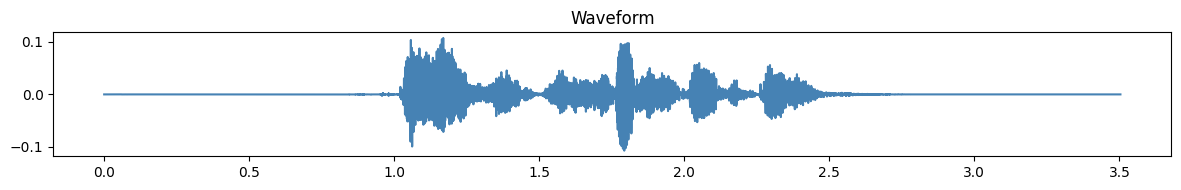

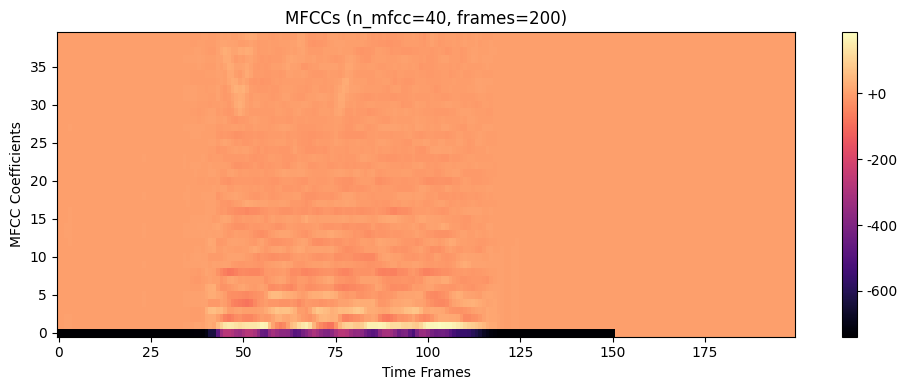

In [ ]:
example_file = "/content/ravdess/Actor_01/03-01-05-01-02-01-01.wav"
mfcc_vis = show_wave_mfcc(example_file)

The waveform shows the shape of the voice. X-axis Time (seconds)
Y-axis Amplitude (loudness or energy)

The MFCC spectrogram shows the texture and tone  the emotional fingerprint hidden in those waves.  X-axis: Time frames
Y-axis: MFCC coefficients frequency information The darker color is more less amplitued in this image

In [ ]:
# X, y = [], []
# for root, dirs, files in os.walk(DATA_PATH):
#     for file in tqdm(files):
#         if file.endswith(".wav"):
#             file_path = os.path.join(root, file)
#             emotion_code = file.split("-")[2]
#             emotion = emotion_dict.get(emotion_code)
#             if emotion:
#                 mfcc = extract_features(file_path)
#                 if mfcc is not None:
#                     X.append(mfcc)
#                     y.append(emotion)


In [ ]:
# The raw feature X and label y lists are converted into NumPy arrays.
# Each audio sample in X represents extracted MFCC features of shape (40, 200), 1440 audio samples
X = np.array(X)
y = np.array(y)
print(" Data shape:", X.shape)

#40  MFCC coefficients (frequency features)My  rows
# 200  Time frames (temporal segments)My columns

 Data shape: (1440, 40, 200)


In [ ]:
X = X[..., np.newaxis]   # (samples, 40, 200, 1) # i coulld also use np.expand_dims(X,-1)# Also adding a new axis as CNN expect same as unsqueeze in Pytorch

#  CNN layers expect a 4D input tensor of shape:
#     (samples, height, width, channels)
# Since our MFCC spectrograms are grayscale (single channel),
# we add a new axis using np.newaxis to create shape
#     (1440, 40, 200, 1)
# This aligns with CNN’s expected input format.

In [ ]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y = to_categorical(y_encoded)#one hot encoded

#LabelEncoder converts categorical emotion names (e.g., "happy", "sad")
#    into integer indices:  "happy", "sad", "angry" as  0, 1, 2
# In 2nd step i  optionally, convert those integer labels into one-hot encoded vectors
#    if using 'categorical_crossentropy' as the loss function
#       Like  2 , [0, 0, 1]

In [ ]:
# The above step helps because deep learning models output probabilities for each class,softmax
#    and one-hot encoding allows the model to compare its predicted probability
#    distribution with the true class (where the max probability corresponds
#    to the correct emotion).

In [ ]:
#Doing my Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (1152, 40, 200, 1) Test: (288, 40, 200, 1)


In [ ]:
from IPython.display import Image

# Displaying  the classic Transformer architecture diagram # Attention is all you need :V
Image(url="https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/Transformer%2C_full_architecture.png/500px-Transformer%2C_full_architecture.png")


# I wanted to emphasis i used the encoder part of the architecture

This block includes

Multi-Head Self-Attention

Feed-Forward Network

Layer Normalization

Residual Connections

I am using the encoder to learn the temporal dependencies between MFCC patches extracted by my CNN

No decoder is needed here because i am  doing classification, not sequence generation or next token prediction

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

#  My  Multi-head Attention block (Its custom with 1 nx layer)
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim=32, num_heads=2, ff_dim=64, rate=0.2,**kwargs):  #32/16
        super().__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)# important fix
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),#expanison to 64 to understand non linear resoning
            layers.Dense(embed_dim),#compression back to original dimension to 32
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)#these are post normalization
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):  #forward pass
        attn_output = self.att(inputs, inputs)   # calculating the attention with q, k transpose dot product and division with root of dimension and extracting from value
        attn_output = self.dropout1(attn_output, training=training) # applying dropout output  to prevent overfitting
        out1 = self.layernorm1(inputs + attn_output)  # layer norm on residual plus attention ouput

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


Each of my  Feed-Forward Network typically has  Two layers

One is wwith Dense layer with ReLU activation

Another Dense layer projecting back to the embedding dimension

So if my
Input= embed_dim

Hidden: ff_dim (I used 64) for expansion to understand non  linearities

Output is makinmg it  back to embed_dim 32

If embed_dim = 32 and ff_dim = 64:

First layer expands 32 to 64 (non-linear reasoning)

Second layer compresses 64 to 32 (to original dimension)

Residual ensures original info is not lost

Creating a chart to shows the steps in Above transformer architecture post layer norm has been incoporated here


<pre>

[Input
   │
   
Multi-Head Attention
   │
Dropout
   │
Residual Add (inputs + attn)
   │
LayerNorm1  ( normalization here)
   │
Feed-Forward Network  I have 2 dense layers
   │
Dropout
   │
Residual Add (out1 + ffn)  residual connection original in resnet to prevent vanishing gardient problem
   │
LayerNorm2 ( normalization here)
   │
Final Encoder Output (contextual embeddings)   (to next encoder if multiple nx layers in my case only 1 encoder layer is there or else decoder if any generation task)
   |
[Global Average Pooling / Flatten]
   │
Dense Layer (8 units to  logits) as 8 emotions
   │
Softmax (convert logits  to emotion probabilities)
   |
[Final Output: Emotion class]





In [ ]:
# MY  Positional Embedding Layer as Transformers do not have inheritent understanding of postion the process everything parallely unlike Rnn which is sequential
class PositionalEmbedding(layers.Layer):
    def __init__(self, max_len, d_model, **kwargs):  #kwargs like name,trainable if any passed in futire pass  safely to keras empty dictionary
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.pos_emb = layers.Embedding(input_dim=max_len, output_dim=d_model)

    def call(self, x):
        # x: (batch, time_steps, d_model)
        positions = tf.range(start=0, limit=tf.shape(x)[1], delta=1)#Delta is difference between consecutive number
        positions = self.pos_emb(positions)
        return x + positions


        # its learnable poitional embedding  not sine-cosine fixed  like for words
        #For images postion is relative not lingustic or semantic  like words
        #same like Vision ttransformers where they also use learnable postional emnbeddings

##WHY I DID NOT USE RNN AND WHY I ADDED Learned Positional  Embedding


Sequential vs. Parallel Processing:
RNNs (including LSTMs and GRUs) process input one step at a time, making them sequential and slow to train, especially on GPUs.
Transformers process all time steps in parallel, making training much faster and highly efficient for large-scale audio datasets.

Gradient Stability:
RNNs often face vanishing or exploding gradient problems as sequence lengths grow.Also using plateuing activation functions like tan H
LSTMs mitigate this using three gates (input, forget, output) and two internal states — the hidden state HT  and the cell state CT —,which help preserve information across time.
GRUs simplify this with two gates (update, reset) and a single hidden state , offering efficiency but at the cost of less memory depth.
Transformers bypass this entire issue by using residual connections and layer normalization, ensuring stable gradient flow during deep training.

Dependency Learning:
RNNs capture short-term dependencies well but tend to forget long-range relationships.
Transformers leverage multi-head self-attention, allowing them to learn global temporal dependencies — for example, connecting MFCC features at timestamp 10 and t 100 directly, without sequential delay.
This gives Transformers near-instant contextual awareness ,temporarly

Context and Memory Handling:
In RNNs, context is stored only in sequential hidden states, which limits the effective receptive field.
Transformers, in contrast, access all positions simultaneously, maintaining global context throughout the sequence  crucial for emotion recognition, where tone progression matters as much as content. I might speak the first letter angrily but thenlater on shift to calm voice

Positional Awareness
Since Transformers process inputs in parallel, they lack an inherent sense of order.
To address this, I added learnable positional embeddings — giving the model a temporal sense of sequence progression.
Unlike fixed sine-cosine embeddings used in NLP ,where vocabulary matters and original transformer architetcure ,Or Rope ,    learnable embeddings adapt dynamically to MFCC-based audio data, similar to Vision Transformers (ViTs) used for images.

Overall Advantage:
The fusion of CNN (local feature extraction) and Transformer (global sequence modeling with positional awareness) creates a hybrid architecture capable of understanding both localized emotion cues and long-range temporal dependencies efficiently making it ideal for speech emotion recognition.

In [ ]:

def  susnata_build_cnn_transformer(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape) #(40, 200, 1)#H,W,C

    #  CNN Feature Extractor — local feature learning
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs) # We can use formula for every line( ( W-K+ 2P)/S +1 ,Since padding same and stride 1 its W/S
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    # Output shape: (H/4, W/4, 32)

    #  Flattening the CNN feature map into a sequence
    seq = layers.Reshape((-1, x.shape[-1]))(x)  # (num_patches, 32)  #500 sequence steps or batch size , each 32 feature vector can be thought of embedding dimension inthis case patches

    #Transformwers need batch size ,seq lenghth and embedding dimension , So H x W turned to 1 dimension

    #  Adding my Learnable Positional Embedding
    max_len = seq.shape[1]#500
    d_model = seq.shape[2]   # embedding dimension (32)
    seq = PositionalEmbedding(max_len=max_len, d_model=d_model)(seq)

    # Transformer Encoder Block my custom class
    transformer_block = TransformerBlock(embed_dim=d_model, num_heads=2, ff_dim=64, rate=0.2)
    x = transformer_block(seq)

    #  Global pooling + my classification head
    x = layers.GlobalAveragePooling1D()(x)  # (batch, 32)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)#did not hard code number of classes for it can change  for me its 8

    # My Final Model
    model = Model(inputs, outputs, name="CNN_Transformer_Model")
    return model

In [ ]:
model = susnata_build_cnn_transformer((40, 200, 1), num_classes=y.shape[1])


In [ ]:
model.summary()  # represenatation of my model below

Model: "CNN_Transformer_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 40, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 200, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 100, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 100, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding_1          │ (None, 500, 32)        │        16,000 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 500, 32)        │         8,544 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,976 (124.91 KB)

 Trainable params: 31,976 (124.91 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
y.shape

(1440, 8)

In [ ]:
print(le.classes_)

['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Build and compiling model
model = susnata_build_cnn_transformer((40, 200, 1), num_classes=y.shape[1])
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting with patience 8
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), #For quick prototyping on the small RAVDESS dataset only 1440,
    #the validation split was reused as the test set to focus on demonstrating the architecture rather than benchmarking accuracy.
    epochs=150,
    batch_size=32,
    callbacks=[early_stop]
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f" Test Accuracy: {test_acc:.2f}")

Epoch 1/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.1130 - loss: 2.1243 - val_accuracy: 0.1042 - val_loss: 2.0862
Epoch 2/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1171 - loss: 2.0889 - val_accuracy: 0.1042 - val_loss: 2.0784
Epoch 3/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1424 - loss: 2.0668 - val_accuracy: 0.1042 - val_loss: 2.0692
Epoch 4/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1349 - loss: 2.0490 - val_accuracy: 0.1319 - val_loss: 2.0634
Epoch 5/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1417 - loss: 2.0517 - val_accuracy: 0.1146 - val_loss: 2.0559
Epoch 6/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1530 - loss: 2.0535 - val_accuracy: 0.1493 - val_loss: 2.0517
Epoch 7/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1639 - loss: 2.0377 - val_accuracy: 0.1424 - val_loss: 2.0492
Epoch 8/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1877 - loss: 2.0315 - val_accuracy: 0.

###  Training Summary
- **Dataset:** RAVDESS (1440 audio files)
- **Optimizer:** Adam(learning_rate=1e-4)
- **Loss:** Categorical Crossentropy
- **Batch Size:** 32
- **Epochs:** 150 (with EarlyStopping, patience=8)
- **Train Accuracy:** ~46%
- **Validation Accuracy:** ~39%
- **Final Test Accuracy:** ~38%

#For quick prototyping on the small RAVDESS dataset only 1440,
    #the validation split was reused as the test set to focus on demonstrating the architecture rather than benchmarking accuracy.
---

###  My take Why Accuracy is Subpar

This model wasn’t built for high accuracy; it was built to **demonstrate architecture**.

Still, several realistic factors explain the moderate performance:

1. ** My  Small Dataset Size**
   - 1440 samples for 8 emotion classes = only 180 samples per emotion.
   - Transformers thrive on large data; with limited examples, they underfit.

2. ** Speaker & Recording Variance**
   - RAVDESS actors have varied tones, accents, and recording conditions.
   - No data augmentation (pitch/time stretching) reduces robustness.We can add that

3. ** Limited Model Depth**
   - Only one Transformer Encoder layer.
   - Adding 2–3 stacked encoder blocks may improve context capture.But i experimented it was a overkill for this small dataset

4. ** No Pretraining**
   - BERT-like architectures benefit from pretraining on massive speech datasets or NLP taks
   - This model is trained from scratch, learning everything from limited data.

5. ** Imbalanced Emotion Classes**
   - Some emotions (like calm/neutral) dominate, biasing the softmax predictions.

---

### My Future Improvements

| Improvement | Description |
|--------------|-------------|
|  **Data Augmentation**| Add pitch shift, time stretch, noise injection, or SpecAugment to diversify samples. |
|  **Deeper Transformer Stack** | Use multiple encoder layers (Nx=2–4) with dropout regularization. |
|  **Pretrained Audio Embeddings** | Use pretrained models like Wav2Vec2
|**Balanced Sampling** | Apply `class_weight` or SMOTE for label imbalance.|


---

In [ ]:
model.save("susnata_build_cnn_transformer_best.h5")

In [ ]:
import numpy as np  # this is where early stopping kicked in

best_epoch = np.argmin(history.history['val_loss']) + 1
       # traing logs show epoch numbers  from 1  not 0, that is like if lowest validation loss happened at index 2 then its epoch 3 that was running also we are taking np argmin epoch 3 will return 2
print(f"Best epoch: {best_epoch}")
print(f"Best validation accuracy: {history.history['val_accuracy'][best_epoch-1]:.4f}") # best epoch aliging correct with actual epoch and printing it
print(f"Best validation loss: {history.history['val_loss'][best_epoch-1]:.4f}")

Best epoch: 86
Best validation accuracy: 0.3785
Best validation loss: 1.5912


In [ ]:
!ls -lh /content

In [ ]:
model.save("/content/susnata_cnn_transformer_emotion2.h5") # saving runtime but will get removed once runtime disconnects

import joblib
joblib.dump(le, "/content/label_encoder2.pkl")

print(" Model and encoder saved ")

 Model and encoder saved 


In [ ]:
from google.colab import files
files.download("/content/susnata_cnn_transformer_emotion2.h5")
files.download("/content/label_encoder2.pkl")  # saviing in local computer

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Susnata's Summary

This notebook demonstrates how a **CNN + Transformer Encoder hybrid** can be applied to speech emotion recognition.  
While accuracy may seem moderate, the architecture successfully:
- Extracts **local spectral patterns** (CNN)
- Learns **global temporal relationships** (Transformer)
- Outputs **emotion probabilities** via a lightweight softmax head.

This makes it a strong *conceptual showcase* for Transformer integration into audio pipelines which is a solid step toward
advanced speech  recognition



I will reiterate again “This project’s goal wasn’t to hit 90% accuracy — it was to *build and understand a working Transformer pipeline*
 from scratch for audio. The results show potential and open room for scaling.”  


In [ ]:
# I have further created a stremlit application to prototype it for quick POC